# UNSUPERVISED LEARNING ON CITY OF SCOTTSDALE CITATIONS

### To Investigate:

Am I able to spot clusters when people of specific demographics receive certain types of citations?  To achieve this goal I will:

1. Apply dimensionality reduction techniques to visualize the observations.
1. Apply clustering techniques to group together similar observations.

In each of the tasks above, try alternative methods and select a best performing one. Discuss how dimensionality reduction and clustering algorithms enable you to gain insights regarding the data.

### Data Source
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes one prior years worth citations.  These citations are largely made up of vehicle related infractions such as speeding.  


I downloaded the data in September 2018, September 2019, and January 2020.  In raw format the combined dataset includes just over XXK rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


## DATA PREPROCESSING

In [133]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
%matplotlib inline 
plt.style.use('bmh')

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [25]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [26]:
# convert column labels to lower case and remove spaces from column names
citations.columns = citations.columns.str.replace(' ', '_')
citations.columns = map(str.lower, citations.columns)

In [28]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

In [29]:
# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [30]:
# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

# create month column
citations['month'] = citations['citation_date'].dt.month

# create day of week column
citations['day_of_week'] = citations['citation_date'].dt.dayofweek

# create day of week column
citations['week_of_year'] = citations['citation_date'].dt.weekofyear

# extract the hour of the day from the citation time column
citations['hour_of_day'] = citations['citation_time'].apply(lambda x: str(x)[-4:-2])

# replace blanks with 0
# this happened for citations that took place during the hour of 12am
citations.loc[citations.hour_of_day == '', 'hour_of_day'] = 0
# change data type of hour from object to number
citations.hour_of_day = pd.to_numeric(citations.hour_of_day)

In [31]:
# how many rows and columns are in the dataset?
citations.shape

(56437, 26)

In [32]:
citations.head()

arizona_statute_code  beat                charge_description  citation_#  \
0              28-701A  12.0  Speed Greater Than R&P or Posted     8096915   
1              28-701A  12.0  Speed Greater Than R&P or Posted     8096916   
2              28-701A   7.0  Speed Greater Than R&P or Posted     8096917   
3              28-701A   7.0  Speed Greater Than R&P or Posted     8096918   
4              28-701A  19.0  Speed Greater Than R&P or Posted     8095091   

  citation_date  citation_time citation_type_code citation_type_description  \
0    2019-07-10            747                 CV             Civil Traffic   
1    2019-07-10            800                 CV             Civil Traffic   
2    2019-07-10            853                 CV             Civil Traffic   
3    2019-07-11            843                 CV             Civil Traffic   
4    2019-07-06           2215                 CV             Civil Traffic   

             cited_person  cited_person_age cited_person_ethnicity  \
0     Hansen, Christopher              19.0                      N   
1            Koch, JOshua              36.0                      N   
2             Dahl, Renee              61.0                      N   
3                Lu, Hung              59.0                      N   
4  Noller-Johnson, Aarron              23.0                      U   

  cited_person_race cited_person_sex        city district   officer_badge_#  \
0                 W                M  Scottsdale       D3  1335               
1                 W                M  Scottsdale       D3  1335               
2                 W                F  Scottsdale       D2  1335               
3                 A                M  Scottsdale       D2  1335               
4                 W                M  Scottsdale       D4  1450               

  state          street street_number  zip  zone  tcmainid  month  \
0    AZ       E Shea Bl          6xxx  NaN  3003    662799      7   
1    AZ       E Shea Bl          6xxx  NaN  3003    662801      7   
2    AZ  N Goldwater Bl          4xxx  NaN  1102    662802      7   
3    AZ  N Goldwater Bl          4xxx  NaN  1102    662804      7   
4    AZ       N Pima Rd          2xxx  NaN  3801    662805      7   

   day_of_week  week_of_year  hour_of_day  
0            2            28            7  
1            2            28            8  
2            2            28            8  
3            3            28            8  
4            5            27           22

identify 10 citation types - limit my dataset to these, use them as my categories
or
use jenks to find 5 natural breaks in age, use these 5 groups as my categories

In [128]:
# identify citation goups that are of a similar size
citations.charge_description.value_counts()[0:20]

Speed Greater Than R&P or Posted                 13355
Expired/No Arizona Registration                   4601
Suspended/Revoked D.L.                            3383
DUI-Impaired to Slightest Degree                  2744
Failure to Control Speed to Avoid A Collision     2670
No Proof of Insurance                             2515
Drug Paraphernalia-Possess/Use                    2507
Fail to Obey Traffic Control Device               1870
Fail to Stop For Red Signal                       1533
Fail to Stop at Stop Sign                         1471
Exceed Limit By More Than 20mph                   1257
Exceed 15mph In School Crossing                    998
Urinate/Defecate In Public                         951
Void Charge                                        847
Fail to Yield Turning Left at Intersection         646
Display M.I. Suspended Plate                       643
Shoplifting-Removal of Goods                       637
Unsafe Lane Change                                 620
Suspended 

In [43]:
# identify citation goups that are of a similar size
len(citations.charge_description.value_counts()[2:12].index)

10

In [46]:
# identify citation goups that are of a similar size
citation_groups = list(citations.charge_description.value_counts()[2:12].index)

In [47]:
citation_groups

['Suspended/Revoked D.L.',
 'DUI-Impaired to Slightest Degree',
 'Failure to Control Speed to Avoid A Collision',
 'No Proof of Insurance',
 'Drug Paraphernalia-Possess/Use',
 'Fail to Obey Traffic Control Device',
 'Fail to Stop For Red Signal',
 'Fail to Stop at Stop Sign',
 'Exceed Limit By More Than 20mph',
 'Exceed 15mph In School Crossing']

In [48]:
# subset full citation dataset with only the top 20 citations by count
ten_citations = citations[citations.charge_description.isin(citation_groups)]

In [49]:
ten_citations.shape

(20948, 26)

In [51]:
ten_citations.head()

arizona_statute_code  beat                             charge_description  \
10             28-4135C  12.0                          No Proof of Insurance   
20             28-3473A  18.0                         Suspended/Revoked D.L.   
24             13-3415A  15.0                 Drug Paraphernalia-Possess/Use   
27              28-701A   1.0  Failure to Control Speed to Avoid A Collision   
29          28-701.02A2  10.0                Exceed Limit By More Than 20mph   

    citation_# citation_date  citation_time citation_type_code  \
10     2086337    2019-07-05           2349                 CV   
20     2048948    2019-07-15           1414                 CT   
24     2088207    2019-07-13           1400                 CR   
27     2087778    2019-07-15           1750                 CV   
29     2087820    2019-07-15           1920                 CT   

   citation_type_description        cited_person  cited_person_age  \
10             Civil Traffic    JOhnson, Credena              34.0   
20          Criminal Traffic    Garcia, Cristian              21.0   
24                  Criminal     Maren, Patricia              43.0   
27             Civil Traffic  Flaaen-Hanna, Lynn              58.0   
29          Criminal Traffic   Viadero, Patricio              22.0   

   cited_person_ethnicity cited_person_race cited_person_sex        city  \
10                      N                 B                F  Scottsdale   
20                      H                 W                M  Scottsdale   
24                      N                 W                F  Scottsdale   
27                      N                 W                F  Scottsdale   
29                      N                 W                M  Scottsdale   

   district   officer_badge_# state                          street  \
10       D3  1487                AZ         N 84th St / E Cactus Rd   
20       D4  1100                AZ                L101 / N Pima Rd   
24       D4  1524                AZ    E Acoma DR / N Scottsdale Rd   
27       D1  1501                AZ    N Hayden Rd / E McKellips Rd   
29       D3  1274                AZ  N Hayden Rd / E Via De Ventura   

   street_number  zip  zone  tcmainid  month  day_of_week  week_of_year  \
10           xxx  NaN  3110    662812      7            4            27   
20           xxx  NaN  3802    662825      7            0            29   
24           xxx  NaN  3401    662830      7            5            28   
27           xxx  NaN   103    662835      7            0            29   
29           xxx  NaN  2606    662839      7            0            29   

    hour_of_day  
10           23  
20           14  
24           14  
27           17  
29           19

In [78]:
# examine for null values
ten_citations.isnull().sum()

arizona_statute_code             0
beat                            82
charge_description               0
citation_#                       0
citation_date                    0
citation_time                    0
citation_type_code               0
citation_type_description        0
cited_person                     0
cited_person_age                 0
cited_person_ethnicity           4
cited_person_race                0
cited_person_sex                 1
city                            13
district                       310
officer_badge_#                  0
state                           16
street                           0
street_number                    0
zip                          19905
zone                             0
tcmainid                         0
month                            0
day_of_week                      0
week_of_year                     0
hour_of_day                      0
dtype: int64

In [63]:
# select last 4 columns with date information
ten_citations.iloc[:,-4:]

month  day_of_week  week_of_year  hour_of_day
10         7            4            27           23
20         7            0            29           14
24         7            5            28           14
27         7            0            29           17
29         7            0            29           19
...      ...          ...           ...          ...
22417      9            5            39           14
22418      9            5            39           22
22419      9            5            39           22
22422     10            1            40           16
22424     10            3            40           11

[20948 rows x 4 columns]

In [53]:
ten_citations[['charge_description',
              'cited_person_age',
              'cited_person_sex']]

charge_description  cited_person_age  \
10                             No Proof of Insurance              34.0   
20                            Suspended/Revoked D.L.              21.0   
24                    Drug Paraphernalia-Possess/Use              43.0   
27     Failure to Control Speed to Avoid A Collision              58.0   
29                   Exceed Limit By More Than 20mph              22.0   
...                                              ...               ...   
22417                    Fail to Stop For Red Signal              20.0   
22418                          No Proof of Insurance              27.0   
22419                      Fail to Stop at Stop Sign              35.0   
22422  Failure to Control Speed to Avoid A Collision              22.0   
22424                         Suspended/Revoked D.L.              42.0   

      cited_person_sex  
10                   F  
20                   M  
24                   F  
27                   F  
29                   M  
...                ...  
22417                M  
22418                M  
22419                F  
22422                M  
22424                F  

[20948 rows x 3 columns]

In [80]:
# combine columns
pd.concat([ten_citations[['cited_person_age',
            'cited_person_sex']], 
             ten_citations.iloc[:,-4:]], axis=1)

cited_person_age cited_person_sex  month  day_of_week  week_of_year  \
10                 34.0                F      7            4            27   
20                 21.0                M      7            0            29   
24                 43.0                F      7            5            28   
27                 58.0                F      7            0            29   
29                 22.0                M      7            0            29   
...                 ...              ...    ...          ...           ...   
22417              20.0                M      9            5            39   
22418              27.0                M      9            5            39   
22419              35.0                F      9            5            39   
22422              22.0                M     10            1            40   
22424              42.0                F     10            3            40   

       hour_of_day  
10              23  
20              14  
24              14  
27              17  
29              19  
...            ...  
22417           14  
22418           22  
22419           22  
22422           16  
22424           11  

[20948 rows x 6 columns]

In [70]:
# encode 'charge_description' as category
# and extract codes for labeling purposes
ten_citations['charge_description'].astype('category').cat.codes

10       8
20       9
24       1
27       7
29       3
        ..
22417    5
22418    8
22419    6
22422    7
22424    9
Length: 20948, dtype: int8

In [90]:
# assign X and y values
X = pd.get_dummies(pd.concat([ten_citations[['cited_person_age',
            'cited_person_sex']], 
             ten_citations.iloc[:,-4:]], axis=1))

y = ten_citations['charge_description'].astype('category').cat.codes

In [91]:
X.head()

cited_person_age  month  day_of_week  week_of_year  hour_of_day  \
10              34.0      7            4            27           23   
20              21.0      7            0            29           14   
24              43.0      7            5            28           14   
27              58.0      7            0            29           17   
29              22.0      7            0            29           19   

    cited_person_sex_F  cited_person_sex_M  cited_person_sex_U  
10                   1                   0                   0  
20                   0                   1                   0  
24                   1                   0                   0  
27                   1                   0                   0  
29                   0                   1                   0

In [92]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [112]:
pd.Series(y_pred).value_counts()

5    3100
0    3067
1    2663
8    2584
2    2513
6    1983
7    1752
4    1692
9    1592
3       2
dtype: int64

## VISUALIZE CLUSTERS

### PCA

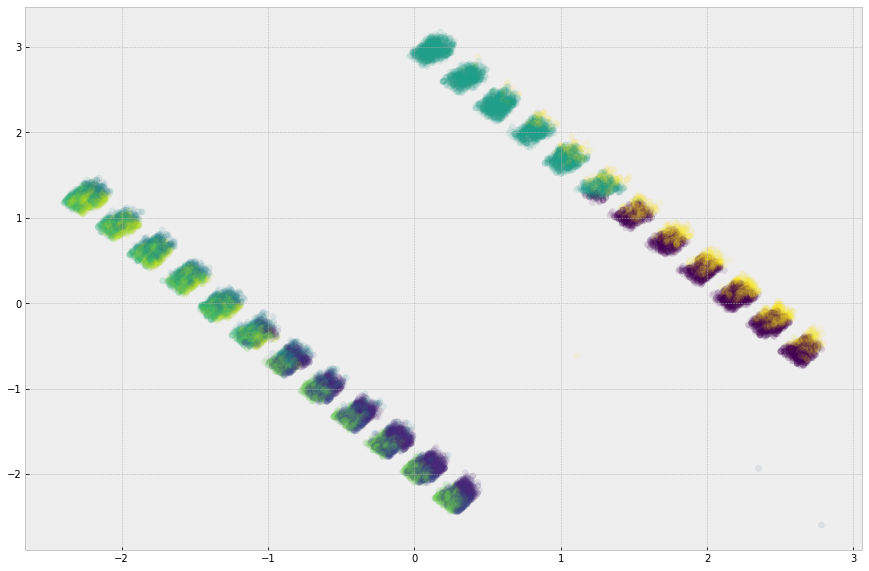

In [113]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=.1)

In [118]:
X_pca

array([[ 1.46479816,  1.07184262],
       [-0.79252016, -0.61986277],
       [ 1.45773801,  1.0308397 ],
       ...,
       [ 1.99515163,  0.28768478],
       [-0.16574893, -1.52828919],
       [ 2.15977609,  0.17772058]])

### t-SNE

In [116]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20948 samples in 0.015s...
[t-SNE] Computed neighbors for 20948 samples in 0.815s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20948
[t-SNE] Computed conditional probabilities for sample 2000 / 20948
[t-SNE] Computed conditional probabilities for sample 3000 / 20948
[t-SNE] Computed conditional probabilities for sample 4000 / 20948
[t-SNE] Computed conditional probabilities for sample 5000 / 20948
[t-SNE] Computed conditional probabilities for sample 6000 / 20948
[t-SNE] Computed conditional probabilities for sample 7000 / 20948
[t-SNE] Computed conditional probabilities for sample 8000 / 20948
[t-SNE] Computed conditional probabilities for sample 9000 / 20948
[t-SNE] Computed conditional probabilities for sample 10000 / 20948
[t-SNE] Computed conditional probabilities for sample 11000 / 20948
[t-SNE] Computed conditional probabilities for sample 12000 / 20948
[t-SNE] Computed conditional probabilities for sa

In [117]:
tsne_results

array([[ 1.3558173 , -0.72297513],
       [ 5.8929887 , -1.3974224 ],
       [-2.0601377 ,  0.2922645 ],
       ...,
       [ 0.8910269 ,  4.952217  ],
       [ 6.804119  ,  1.8327006 ],
       [-1.2312789 ,  4.383005  ]], dtype=float32)

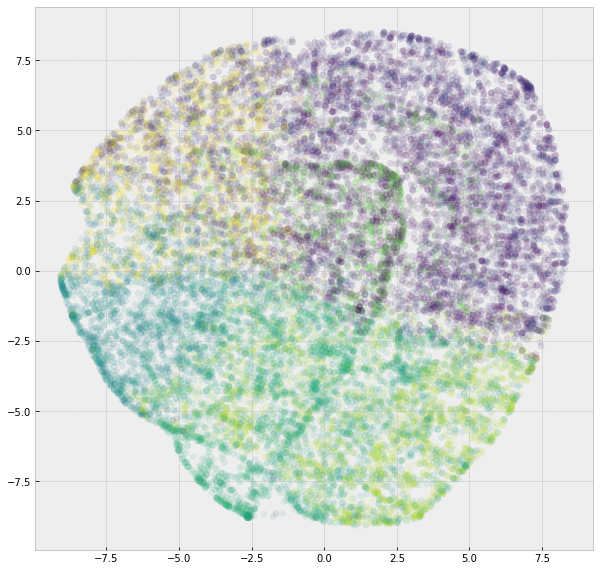

In [121]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.1, c=y_pred)

### UMAP

In [124]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

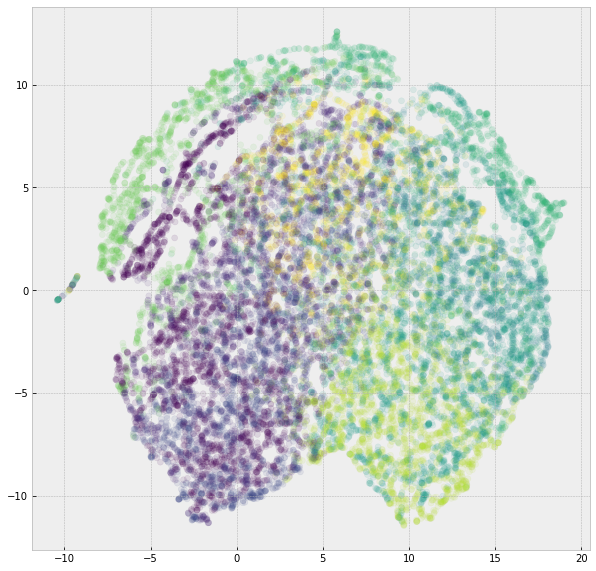

In [125]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=y_pred)

In [126]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X)

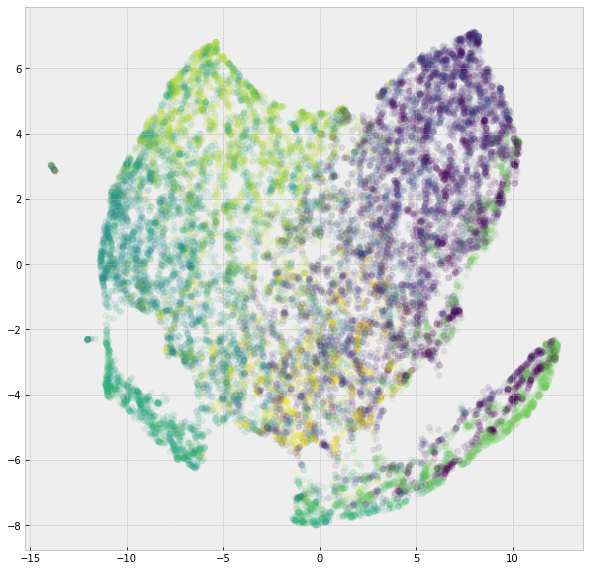

In [127]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=y_pred)

## GROUP CLUSTERS

In [129]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['ARI',
          'silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

## K-means with 10 clusters

In [130]:
# silhouette
labels = KMeans(n_clusters=10, random_state=123).fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

0.217

In [131]:
# ARI
y_pred = KMeans(n_clusters=10).fit_predict(X_std)

results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y, y_pred), 3)
round(metrics.adjusted_rand_score(y, y_pred), 3)

0.011

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [134]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [135]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.005

In [136]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.3

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [137]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [138]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.005

In [139]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.3

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [140]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [141]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.005

In [142]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.297

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [154]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.206

In [155]:
results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.0

## tied

In [143]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [144]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.211

In [145]:
results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.0

## diag

In [146]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [147]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.965

In [148]:
results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.0

## spherical

In [149]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [150]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.206

In [151]:
results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.0

In [157]:
results_df

ARI silhouette
hierarchical - ward      0.005        0.3
hierarchical - complete  0.005        0.3
hierarchical - average   0.005      0.297
k-means                  0.011      0.217
gaussian - full              0      0.206
gaussian - tied              0      0.211
gaussian - diag              0      0.965
gaussian - spherical         0      0.206

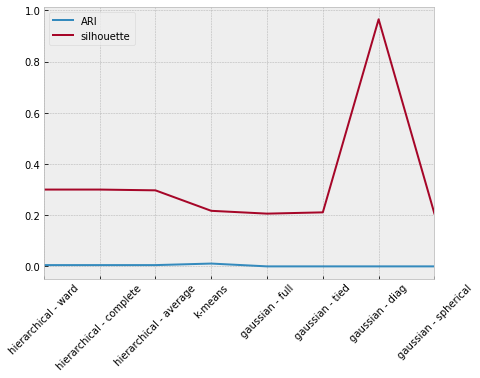

In [156]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);

# identify citations that I think will have specific demographics associated with them

    Fail to Yield Turning Left at Intersection
    Fail to Stop at Stop Sign
    DUI-Impaired to Slightest Degree
    Failure to Control Speed to Avoid A Collision
    Exceed Limit By More Than 20mph

In [164]:
citation_groups = [
    'Fail to Yield Turning Left at Intersection',
    'Fail to Stop at Stop Sign',
    'DUI-Impaired to Slightest Degree',
    'Failure to Control Speed to Avoid A Collision',
    'Exceed Limit By More Than 20mph'
]

In [165]:
# subset full citation dataset with only the top 20 citations by count
five_citations = citations[citations.charge_description.isin(citation_groups)]

In [168]:
five_citations.shape

(8788, 26)

In [172]:
# assign X and y values
X = pd.get_dummies(pd.concat([five_citations[['cited_person_age',
            'cited_person_sex']], 
             five_citations.iloc[:,-4:]], axis=1))

y = five_citations['charge_description'].astype('category').cat.codes

In [173]:
X.head()

cited_person_age  month  day_of_week  week_of_year  hour_of_day  \
27              58.0      7            0            29           17   
29              22.0      7            0            29           19   
31              22.0      7            0            29           19   
32              19.0      7            0            29           20   
36              22.0      7            5            28           11   

    cited_person_sex_F  cited_person_sex_M  cited_person_sex_U  
27                   1                   0                   0  
29                   0                   1                   0  
31                   1                   0                   0  
32                   0                   1                   0  
36                   1                   0                   0

## VISUALIZE CLUSTERS

### PCA

In [176]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

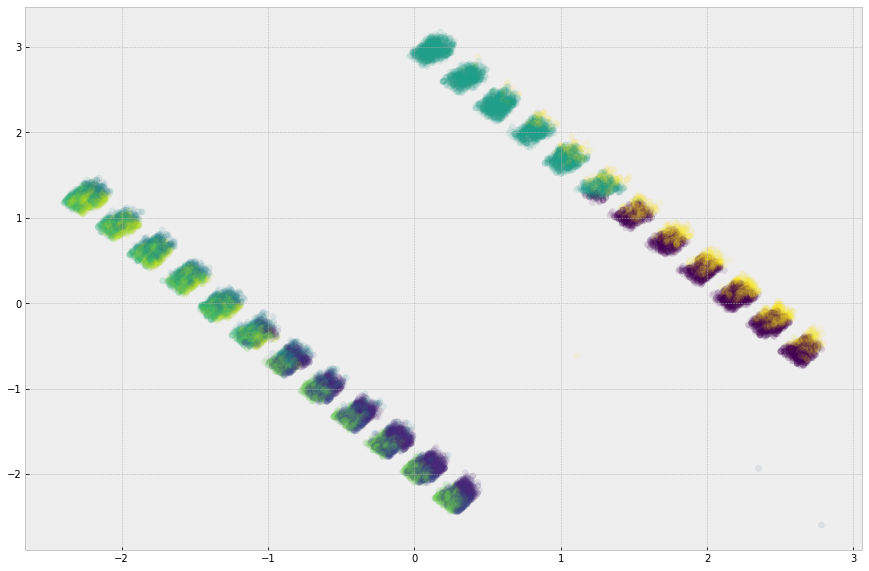

In [113]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=.1)

In [118]:
X_pca

array([[ 1.46479816,  1.07184262],
       [-0.79252016, -0.61986277],
       [ 1.45773801,  1.0308397 ],
       ...,
       [ 1.99515163,  0.28768478],
       [-0.16574893, -1.52828919],
       [ 2.15977609,  0.17772058]])

### t-SNE

In [116]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20948 samples in 0.015s...
[t-SNE] Computed neighbors for 20948 samples in 0.815s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20948
[t-SNE] Computed conditional probabilities for sample 2000 / 20948
[t-SNE] Computed conditional probabilities for sample 3000 / 20948
[t-SNE] Computed conditional probabilities for sample 4000 / 20948
[t-SNE] Computed conditional probabilities for sample 5000 / 20948
[t-SNE] Computed conditional probabilities for sample 6000 / 20948
[t-SNE] Computed conditional probabilities for sample 7000 / 20948
[t-SNE] Computed conditional probabilities for sample 8000 / 20948
[t-SNE] Computed conditional probabilities for sample 9000 / 20948
[t-SNE] Computed conditional probabilities for sample 10000 / 20948
[t-SNE] Computed conditional probabilities for sample 11000 / 20948
[t-SNE] Computed conditional probabilities for sample 12000 / 20948
[t-SNE] Computed conditional probabilities for sa

In [117]:
tsne_results

array([[ 1.3558173 , -0.72297513],
       [ 5.8929887 , -1.3974224 ],
       [-2.0601377 ,  0.2922645 ],
       ...,
       [ 0.8910269 ,  4.952217  ],
       [ 6.804119  ,  1.8327006 ],
       [-1.2312789 ,  4.383005  ]], dtype=float32)

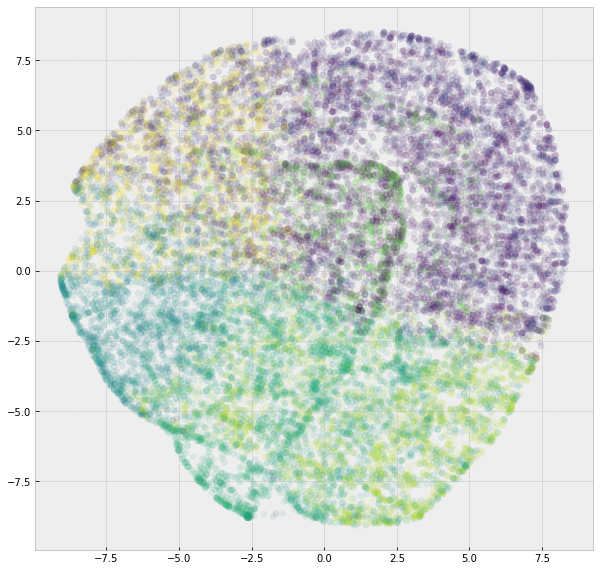

In [121]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.1, c=y_pred)

### UMAP

In [124]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

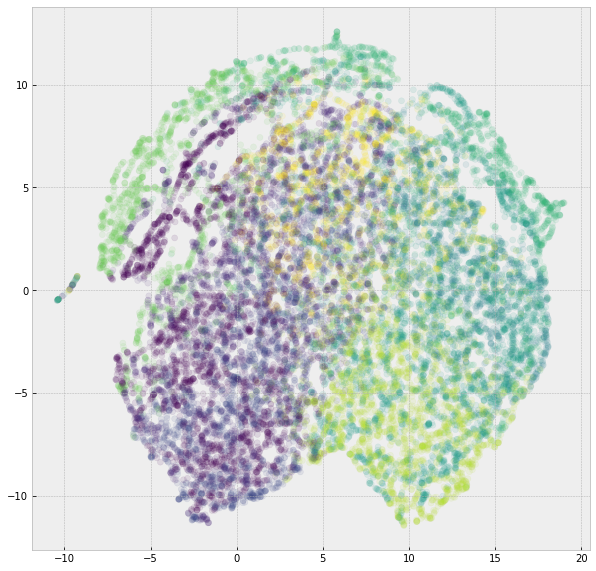

In [125]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=y_pred)

In [126]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X)

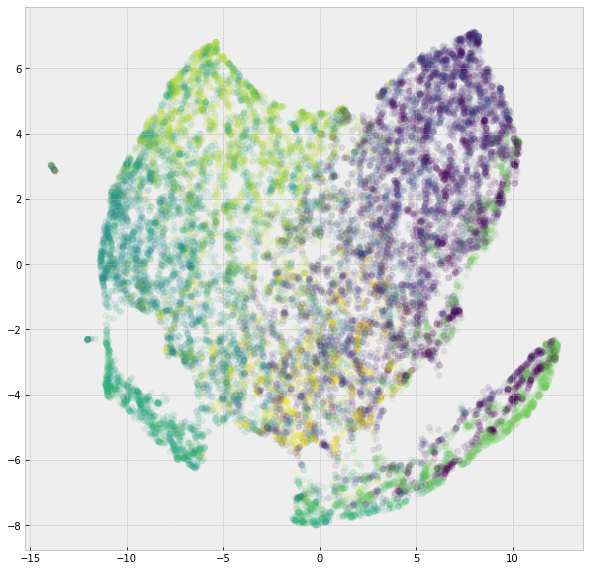

In [127]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=y_pred)

## GROUP CLUSTERS AND EXAMINE FIT OF GROUPINGS

In [178]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['ARI',
          'silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

## K-means with 5 clusters

In [259]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

0.231

In [260]:
# ARI
y_pred = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y, y_pred), 3)
round(metrics.adjusted_rand_score(y, y_pred), 3)

0.005

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [261]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [262]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.004

In [263]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.248

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [264]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [265]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.011

In [266]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.15

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [267]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [268]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.007

In [269]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.247

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [270]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [271]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.139

In [272]:
results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.005

## tied

In [273]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [274]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.273

In [275]:
results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.005

## diag

In [276]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [277]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.267

In [278]:
results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.004

## spherical

In [279]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [280]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.273

In [281]:
results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.005

In [282]:
results_df

ARI silhouette
hierarchical - ward      0.004      0.248
hierarchical - complete  0.011       0.15
hierarchical - average   0.007      0.247
k-means                  0.005      0.231
gaussian - full          0.005      0.139
gaussian - tied          0.005      0.273
gaussian - diag          0.004      0.267
gaussian - spherical     0.005      0.273

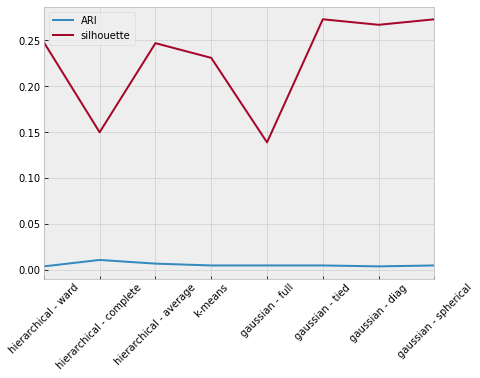

In [283]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);

# Revisit computations for above amounts

## diag - visualize

In [284]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [285]:
pd.Series(clusters).value_counts()

1    2903
0    2441
2    1872
4    1571
3       1
dtype: int64

In [288]:
pd.Series(clusters)[pd.Series(clusters) == 3]

5667    3
dtype: int64

In [313]:
X

cited_person_age  month  day_of_week  week_of_year  hour_of_day  \
27                 58.0      7            0            29           17   
29                 22.0      7            0            29           19   
31                 22.0      7            0            29           19   
32                 19.0      7            0            29           20   
36                 22.0      7            5            28           11   
...                 ...    ...          ...           ...          ...   
22373              46.0     10            2            40           18   
22375              21.0     10            2            40           16   
22379              70.0     10            2            40           18   
22419              35.0      9            5            39           22   
22422              22.0     10            1            40           16   

       cited_person_sex_F  cited_person_sex_M  cited_person_sex_U  
27                      1                   0                   0  
29                      0                   1                   0  
31                      1                   0                   0  
32                      0                   1                   0  
36                      1                   0                   0  
...                   ...                 ...                 ...  
22373                   0                   1                   0  
22375                   1                   0                   0  
22379                   0                   1                   0  
22419                   1                   0                   0  
22422                   0                   1                   0  

[8788 rows x 8 columns]

In [299]:
(pd.Series(clusters) == 3)

0       False
1       False
2       False
3       False
4       False
        ...  
8783    False
8784    False
8785    False
8786    False
8787    False
Length: 8788, dtype: bool

In [312]:
pd.concat([X, pd.Series(clusters)], axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

## VISUALIZE CLUSTERS

### PCA

In [248]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

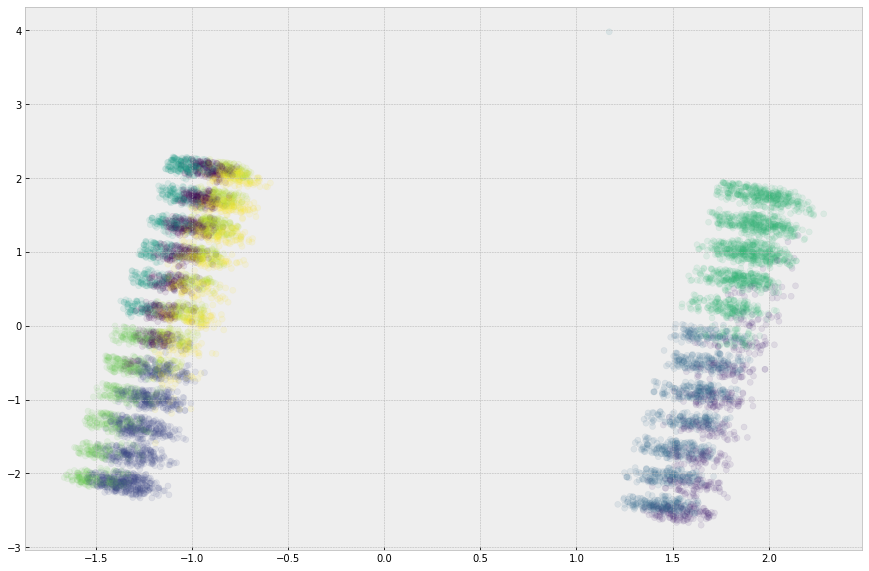

In [249]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=.1)

In [208]:
X_pca

array([[ 1.96673644, -0.26136096],
       [-0.97399611,  0.199303  ],
       [ 1.88481298, -0.14399311],
       ...,
       [-0.80907301,  1.12285429],
       [ 1.82316983,  0.68614051],
       [-0.90499884,  1.28109959]])

### t-SNE

In [250]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8788 samples in 0.008s...
[t-SNE] Computed neighbors for 8788 samples in 0.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8788
[t-SNE] Computed conditional probabilities for sample 2000 / 8788
[t-SNE] Computed conditional probabilities for sample 3000 / 8788
[t-SNE] Computed conditional probabilities for sample 4000 / 8788
[t-SNE] Computed conditional probabilities for sample 5000 / 8788
[t-SNE] Computed conditional probabilities for sample 6000 / 8788
[t-SNE] Computed conditional probabilities for sample 7000 / 8788
[t-SNE] Computed conditional probabilities for sample 8000 / 8788
[t-SNE] Computed conditional probabilities for sample 8788 / 8788
[t-SNE] Mean sigma: 2.526750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.720909
[t-SNE] KL divergence after 300 iterations: 2.339168


In [210]:
tsne_results

array([[-3.5615444,  1.8081762],
       [ 9.307054 ,  1.8915052],
       [ 9.29312  ,  1.8866938],
       ...,
       [-8.425256 ,  4.8167725],
       [ 1.2306613,  5.5363297],
       [ 8.609343 ,  5.795727 ]], dtype=float32)

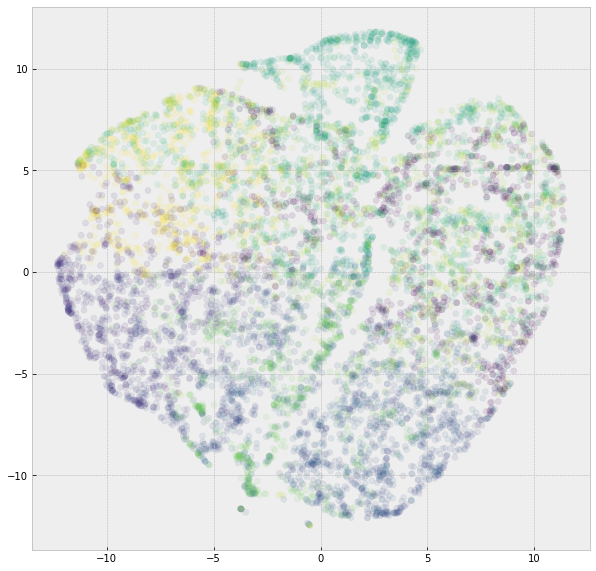

In [251]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.1, c=y_pred)

### UMAP

In [252]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

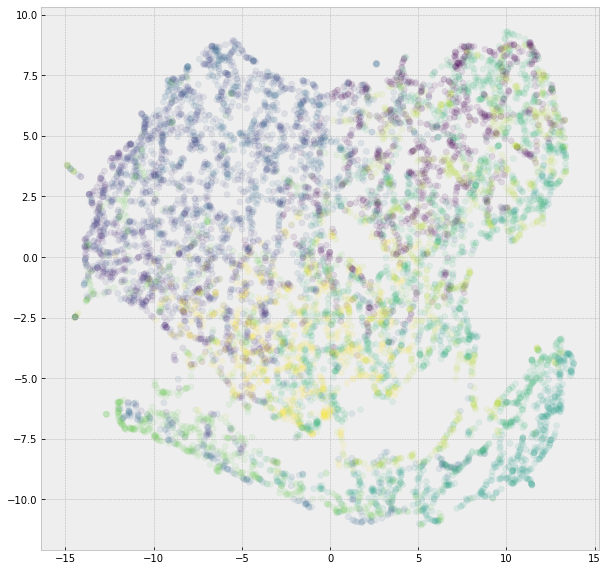

In [253]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=y_pred)

In [254]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X)

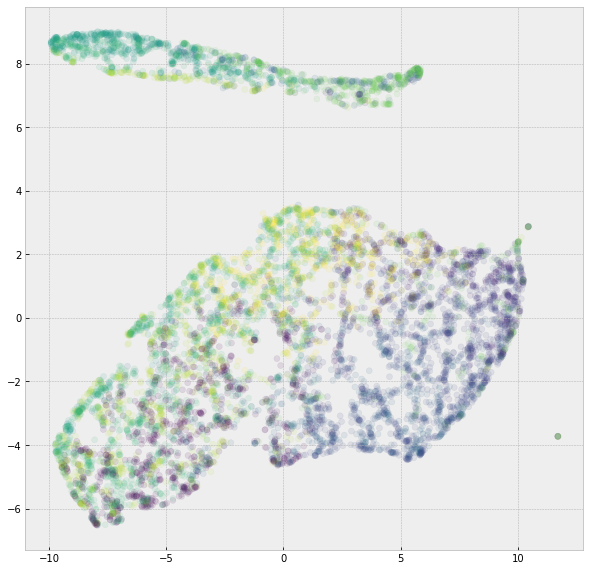

In [255]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=y_pred)

## Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [230]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

## VISUALIZE CLUSTERS

### PCA

In [231]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

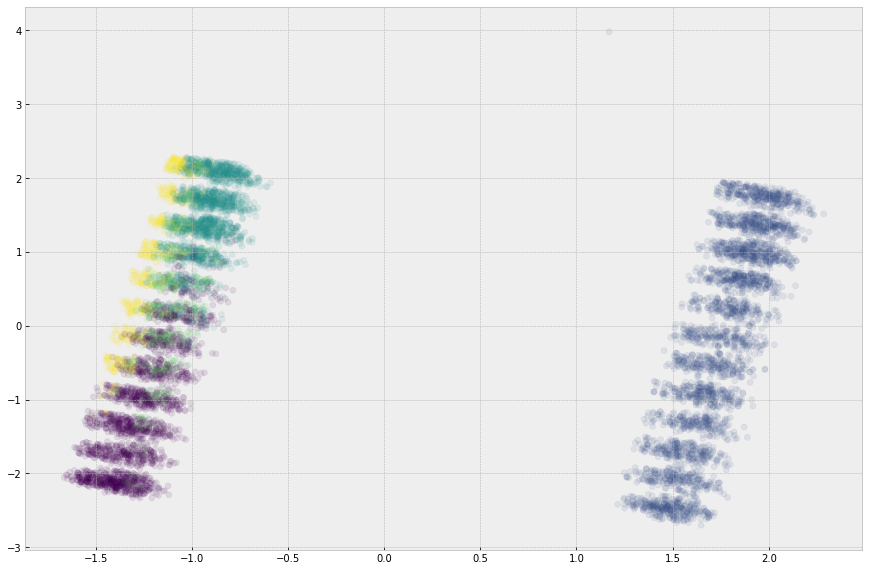

In [232]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, alpha=.1)

In [219]:
X_pca

array([[ 1.96673644, -0.26136096],
       [-0.97399611,  0.199303  ],
       [ 1.88481298, -0.14399311],
       ...,
       [-0.80907301,  1.12285429],
       [ 1.82316983,  0.68614051],
       [-0.90499884,  1.28109959]])

### t-SNE

In [220]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8788 samples in 0.006s...
[t-SNE] Computed neighbors for 8788 samples in 0.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8788
[t-SNE] Computed conditional probabilities for sample 2000 / 8788
[t-SNE] Computed conditional probabilities for sample 3000 / 8788
[t-SNE] Computed conditional probabilities for sample 4000 / 8788
[t-SNE] Computed conditional probabilities for sample 5000 / 8788
[t-SNE] Computed conditional probabilities for sample 6000 / 8788
[t-SNE] Computed conditional probabilities for sample 7000 / 8788
[t-SNE] Computed conditional probabilities for sample 8000 / 8788
[t-SNE] Computed conditional probabilities for sample 8788 / 8788
[t-SNE] Mean sigma: 2.526750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.423141
[t-SNE] KL divergence after 300 iterations: 2.308089


In [221]:
tsne_results

array([[-0.08092114,  6.635985  ],
       [ 0.5735714 , -3.537137  ],
       [ 0.5682705 , -3.552368  ],
       ...,
       [ 2.6947536 ,  9.7558565 ],
       [ 5.822845  ,  0.9857258 ],
       [ 5.410703  , -4.3665085 ]], dtype=float32)

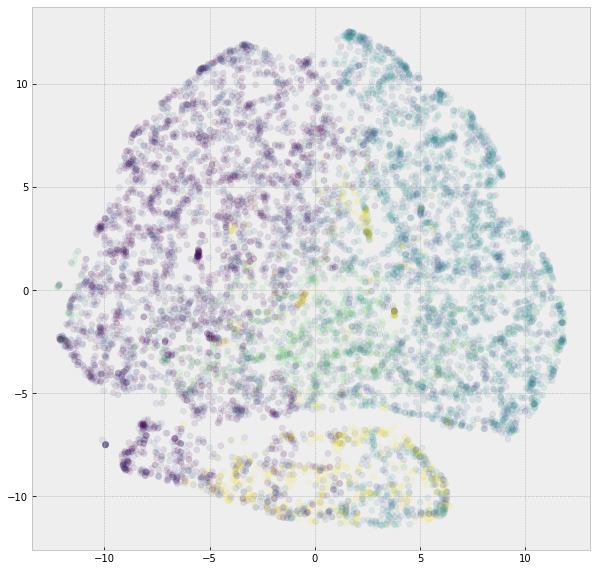

In [233]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.1, c=clusters)

### UMAP

In [236]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

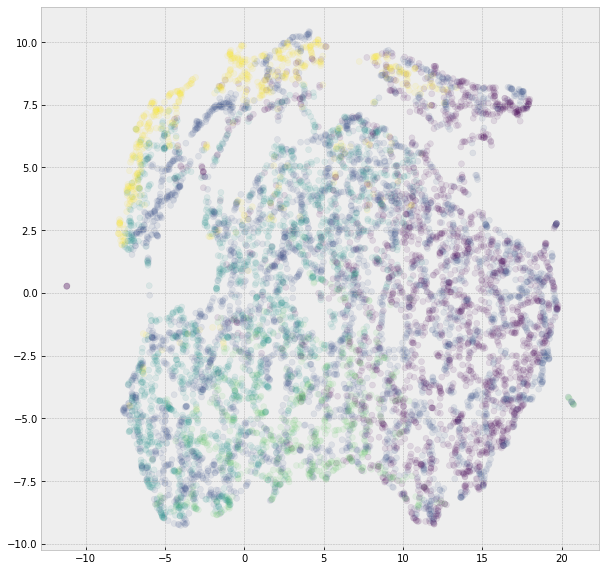

In [237]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=clusters)

In [238]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X)

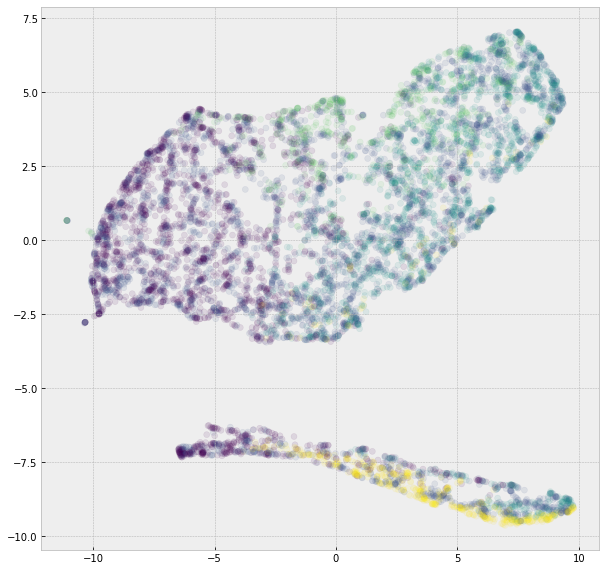

In [239]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.1, c=clusters)